# Benchmarking Tabular ML Datasets
Thom, Jakob and Marit

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

## Load in Data

In [3]:
def load_df(filename, foldername='aml-2025-benchmarking-tabular-ml-datasets'):
    return pd.read_csv(f'{foldername}/{filename}', header=0)

In [4]:
covtype_test = load_df('covtype_test.csv')
covtype_train = load_df('covtype_train.csv')
heloc_test = load_df('heloc_test.csv')
heloc_train = load_df('heloc_train.csv')
higgs_test = load_df('higgs_test.csv')
higgs_train = load_df('higgs_train.csv')

# Make all target columns have the name 'target'
covtype_train.rename(columns={'Cover_Type' : 'label'}, inplace=True)
heloc_train.rename(columns={'RiskPerformance' : 'label'}, inplace=True)
higgs_train.rename(columns={'Label' : 'label'}, inplace=True)

In [5]:
tables_test = [covtype_test, heloc_test, higgs_test]
tables_train = [covtype_train, heloc_train, higgs_train]
names = ['CoverType', 'HELOC', 'Higgs']

## Data Exploration

In [6]:
# Very general quantification of the datasets
for table, name in zip(tables_train, names):
    print(name)
    print('Number of columns:', len(table.columns))
    print('Number of rows:', len(table))
    print('Number of classes:', len(table['label'].unique()))
    print()


CoverType
Number of columns: 55
Number of rows: 58101
Number of classes: 7

HELOC
Number of columns: 24
Number of rows: 9413
Number of classes: 2

Higgs
Number of columns: 33
Number of rows: 175000
Number of classes: 2



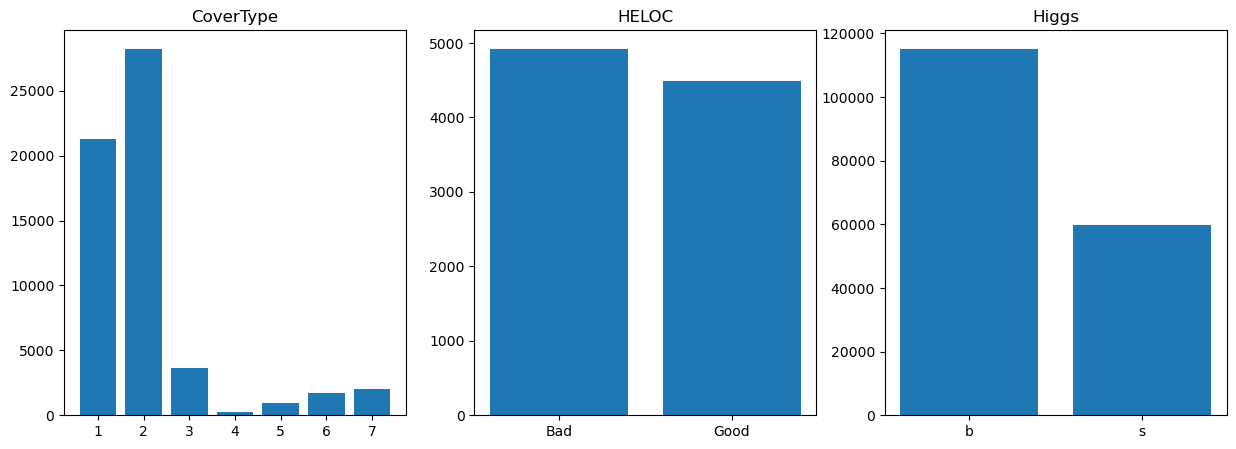

In [7]:
fig, axs = plt.subplots(nrows=1, 
                        ncols=3,
                        figsize=(15,5))

for i in range(len(tables_train)):
    labels, counts = np.unique(tables_train[i]['label'], return_counts=True)
    axs[i].bar(labels, counts, align='center')
    axs[i].set_title(names[i])

# fig

## Combine and clean datasets


In [8]:
# Labels to convert
binary_labels = {
    'Bad': 1,
    'Good': 0,
    's': 1,
    'b': 0
    }

def clean_and_combine(tables, names, binary_labels = None):
    
    cleaned_tables = []

    for table, name in zip(tables, names):
        t = table.copy()

        # Get numerical columns for this specific table
        numerical_cols = t.select_dtypes(include=np.number).columns.tolist()

        # Clean missing values based on domain and remove id column
        if name == 'HELOC':
            for col in numerical_cols:
                t.loc[t[col] < 0, col] = np.nan
        elif name == 'HIGGS':
            t.replace(-999.0, np.nan, inplace=True)
            t = t.drop('EventId')

        # Add domain name
        t['Domain'] = name
        cleaned_tables.append(t)
        
    unified_df = pd.concat(cleaned_tables, ignore_index=True)

    # Handle target labels if provided (Training Data)
    if binary_labels:
        unified_df['label'] = unified_df['label'].astype(str).replace(binary_labels)       # As string first to prevent downcasting warning
        unified_df['label'] = unified_df['label'].astype(int)
    return unified_df

## These are some different models


In [ ]:

# catboost = Pipeline([
#     ("preprocessor", unified_preprocessor),
#     ("clf", CatBoostClassifier(
#         iterations=1000, 
#         learning_rate=0.05,
#         depth=6,             # Start shallower than XGBoost
#         loss_function='MultiClass',
#         verbose=0,
#         random_state=42,
#         auto_class_weights='Balanced' # Critical for CoverType imbalance
#     ))
# ])




# xgboost = Pipeline([
#     ("preprocessor", unified_preprocessor),
#     ("clf", XGBClassifier(
#         n_estimators=500,
#         learning_rate=0.05,
#         max_depth=10,
#         tree_method='hist',
#         n_jobs=-1,
#         random_state=42,
#     ))
#     ])




# lightxgboost = Pipeline([
#         ("preprocessor", unified_preprocessor),
#         ("clf", LGBMClassifier(
#             n_estimators=300,
#             learning_rate=0.05,
#             num_leaves=31,
#             # fix for imbalance in CoverType classes
#             class_weight='balanced', 
#             random_state=random_state,
#             n_jobs=-1
#         ))
#     ])



# mlp  = Pipeline([
#     ("preprocessor", unified_preprocessor),
#     ("clf", MLPClassifier(
#         hidden_layer_sizes=(256, 128, 64), # 3 deep layers (Heavy!)
#         activation='relu',
#         solver='adam',
#         batch_size=256,
#         max_iter=200,            # Epochs
#         early_stopping=True,     # Stop if validation score stops improving
#         random_state=42
#     ))
# ])

## This is to run one model with single set of parameters


In [ ]:
# def lockandload(df, random_state=42, test_size=0.2, target_col = 'label'):

#     # Separate features and target
#     X = df.drop(target_col, axis=1)
#     y = df[target_col]

#     # Get numerical columns for transformer
#     numerical_cols = X.select_dtypes(include=np.number).columns.tolist()

#     categorical_cols = ['Domain']

#     # Pre processing pipiline
#     unified_preprocessor = ColumnTransformer(
#         transformers=[
#             ('num_processing', Pipeline([
#                 # replace NaN's and use scaler
#                 ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
#                 ('scaler', StandardScaler())
#             ]), numerical_cols),
            
#             ('cat_processing', Pipeline([
#                 # One hot encode the tabular name (Domain)
#                 ('onehot', OneHotEncoder())
#             ]), categorical_cols)
#         ],
#         remainder='drop' 
#     )


#     unified_pipeline  = Pipeline([
#         ("preprocessor", unified_preprocessor),
#         ("clf", LGBMClassifier(
#             n_estimators=300,
#             learning_rate=0.05,
#             num_leaves=31,
#             # fix for imbalance in CoverType classes
#             class_weight='balanced', 
#             random_state=random_state,
#             n_jobs=-1
#         ))
#     ])

#     # Train / test split
#     X_train, X_test, y_train_enc, y_test_enc = train_test_split(
#         X, y,
#         test_size=test_size,
#         stratify=y,
#         random_state=random_state
#     )


#     print("Training unified model")
#     model = (unified_pipeline)
#     model.fit(X_train, y_train_enc)

#     # Evaluate on local test set
#     y_pred_enc = model.predict(X_test)
#     acc = accuracy_score(y_test_enc, y_pred_enc)

#     print(f"\nLocal test accuracy: {acc:.4f}")

#     return model



## Parameter search on lightxgboost

In [ ]:
def lightxg_params(df, random_state=42, test_size=0.2, target_col='label'):
    
    # Separate features and target
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Get numerical columns
    numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
    if 'ID' in numerical_cols: numerical_cols.remove('ID') # Safety check
        
    categorical_cols = ['Domain']

    # 3. Define Preprocessor
    unified_preprocessor = ColumnTransformer(
        transformers=[
            ('num_processing', Pipeline([
                ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
                ('scaler', StandardScaler())
            ]), numerical_cols),
            
            ('cat_processing', Pipeline([
                # handle_unknown='ignore' is crucial for robustness
                ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=int))
            ]), categorical_cols)
        ],
        remainder='drop' 
    )

    # Define Base Pipeline 
    unified_pipeline = Pipeline([
        ("preprocessor", unified_preprocessor),
        ("clf", LGBMClassifier(
            class_weight='balanced', # Keep this fixed
            random_state=random_state,
            n_jobs=1,
            verbose=-1 # Silence LGBM internal logs
        ))
    ])

    # Define Search Space
    param_dist = {
        'clf__n_estimators': randint(100, 1000),      # Number of trees
        'clf__learning_rate': uniform(0.01, 0.2),     # Learning speed
        'clf__num_leaves': randint(20, 150),          # Tree complexity
        'clf__max_depth': randint(5, 20),             # Depth limit
        'clf__min_child_samples': randint(10, 100),   # Regularization
        'clf__subsample': uniform(0.6, 0.4),          # Bagging fraction
        'clf__colsample_bytree': uniform(0.6, 0.4)    # Feature fraction
    }

    # Train / Test Split
    X_train, X_test, y_train_enc, y_test_enc = train_test_split(
        X, y,
        test_size=test_size,
        stratify=y,
        random_state=random_state
    )

    # Configure Randomized Search
    search = RandomizedSearchCV(
        estimator=unified_pipeline,
        param_distributions=param_dist,
        n_iter=15,            # Try 15 different random combinations
        cv=3,                 # 3-Fold Cross Validation
        scoring='accuracy',
        n_jobs=-1,            # Use all CPU cores
        verbose=1,
        random_state=random_state
    )

    print("Starting Hyperparameter Tuning (RandomizedSearchCV)...")
    search.fit(X_train, y_train_enc)

    # Get Best Model & Results
    best_model = search.best_estimator_
    print(f"\nBest Validation Accuracy (CV): {search.best_score_:.4f}")
    print(f"Best Parameters: {search.best_params_}")

    # Evaluate on Local Test Set
    y_pred_enc = best_model.predict(X_test)
    acc = accuracy_score(y_test_enc, y_pred_enc)

    print(f"Local Test Set Accuracy: {acc:.4f}")

    os.system('say "Your unified model training is finished."')

    # Return the TUNED model so you can use it for submission
    return best_model

## Parameter search on Catboost

In [ ]:
def catboost_params(df, random_state=42, test_size=0.2, target_col='label'):
    
    # Separate features and target
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Get numerical columns
    numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
    if 'ID' in numerical_cols: numerical_cols.remove('ID')
        
    categorical_cols = ['Domain']

    # Define preprocessor 
    unified_preprocessor = ColumnTransformer(
        transformers=[
            ('num_processing', Pipeline([
                ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
                ('scaler', StandardScaler())
            ]), numerical_cols),
            
            ('cat_processing', Pipeline([
                ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=int))
            ]), categorical_cols)
        ],
        remainder='drop' 
    )

    # Pipeline with Catboost
    unified_pipeline = Pipeline([
        ("preprocessor", unified_preprocessor),
        ("clf", CatBoostClassifier(
            loss_function='MultiClass',   # Required for your 11 classes
            auto_class_weights='Balanced',# Handles the CoverType imbalance automatically
            verbose=0,                    # Silence the training output
            random_state=random_state,
            thread_count=-1,              # Use all cores for the model training
            allow_writing_files=False     # Prevents creating 'catboost_info' folders
        ))
    ])

    # Parameters to search
    param_dist = {
        'clf__iterations': randint(500, 1200),
        'clf__depth': randint(4, 9), # Keep max 8!
        'clf__learning_rate': uniform(0.01, 0.2),
        'clf__l2_leaf_reg': randint(1, 10),
        'clf__bagging_temperature': uniform(0, 1),
        'clf__random_strength': uniform(1, 10)
    }

    # Train / Test Split
    X_train, X_test, y_train_enc, y_test_enc = train_test_split(
        X, y,
        test_size=test_size,
        stratify=y,
        random_state=random_state
    )

    # Configure Randomized Search
    # IMPORTANT: n_iter=10 is enough for CatBoost because it trains slower
    search = RandomizedSearchCV(
        estimator=unified_pipeline,
        param_distributions=param_dist,
        n_iter=10,            # Lower than LGBM due to speed
        cv=3,                 
        scoring='accuracy',
        n_jobs=1,             # Sequential search to avoid thread explosion
        verbose=1,
        random_state=random_state
    )

    print("Starting CatBoost Hyperparameter Tuning...")
    search.fit(X_train, y_train_enc)

    # Get Best Model & Results
    best_model = search.best_estimator_
    print(f"\nBest Validation Accuracy (CV): {search.best_score_:.4f}")
    print(f"Best Parameters: {search.best_params_}")

    # Evaluate on Local Test Set
    y_pred_enc = best_model.predict(X_test)
    # CatBoost predict returns an array of shape (N, 1), flatten it
    y_pred_enc = y_pred_enc.ravel() 
    
    acc = accuracy_score(y_test_enc, y_pred_enc)

    print(f"Local Test Set Accuracy: {acc:.4f}")

    os.system('say "Your unified model training is finished."')

    # Return the TUNED model so you can use it for submission
    return best_model

## Predict

In [ ]:
# Load data
df_train = clean_and_combine(tables_train, names, binary_labels)
df_test = clean_and_combine(tables_test, names)

# Train model
model = lightxg_params(df_train)

# Predict on submission test set
predictions = model.predict(df_test)

# Save submission file
submission = pd.DataFrame({"Prediction": predictions}, index=range(1, len(predictions) + 1))

### Only necessary for catboost, output data is different shape ###
# submission = pd.DataFrame({"Prediction": predictions.ravel()}, index=range(1, len(predictions) + 1))

pd.DataFrame(submission).to_csv('combined_test_sample_submission.csv', index=True, index_label="ID")

Starting CatBoost Hyperparameter Tuning...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best Validation Accuracy (CV): 0.9406
Best Parameters: {'clf__bagging_temperature': np.float64(0.4667628932479799), 'clf__depth': 8, 'clf__iterations': 1146, 'clf__l2_leaf_reg': 5, 'clf__learning_rate': np.float64(0.1000998503939086), 'clf__random_strength': np.float64(1.1326496115986653)}
Local Test Set Accuracy: 0.9425


ValueError: Data must be 1-dimensional, got ndarray of shape (79546, 1) instead